In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
electric_data = pd.read_csv('dataset/Electric_Production.csv')
electric_data['DATE'] = pd.to_datetime(electric_data['DATE'])
electric_data.set_index('DATE', inplace=True)
print(electric_data)

            IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
...                ...
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048

[397 rows x 1 columns]


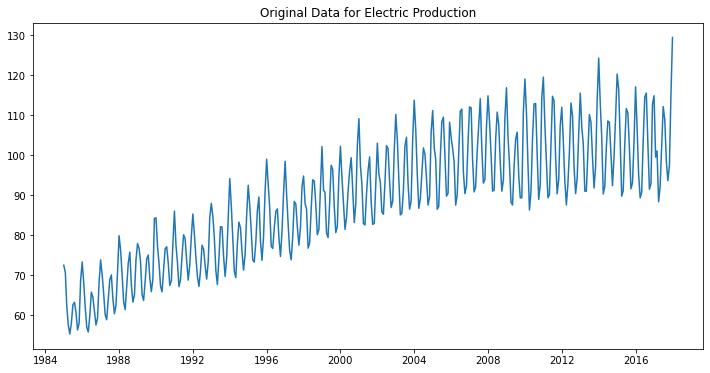

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(electric_data['IPG2211A2N'])
plt.title('Original Data for Electric Production')
plt.show()

In [4]:
rolmean = electric_data['IPG2211A2N'].rolling(window=12).mean()
rolvar = electric_data['IPG2211A2N'].rolling(window=12).var()  

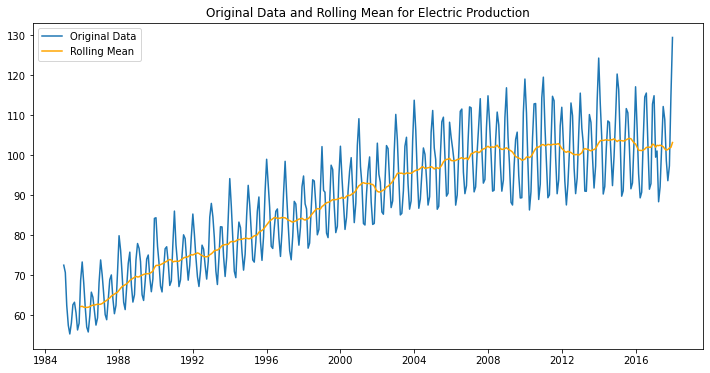

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(electric_data['IPG2211A2N'], label='Original Data')
plt.plot(rolmean, label='Rolling Mean', color='orange')
plt.title('Original Data and Rolling Mean for Electric Production')
plt.legend()
plt.show()

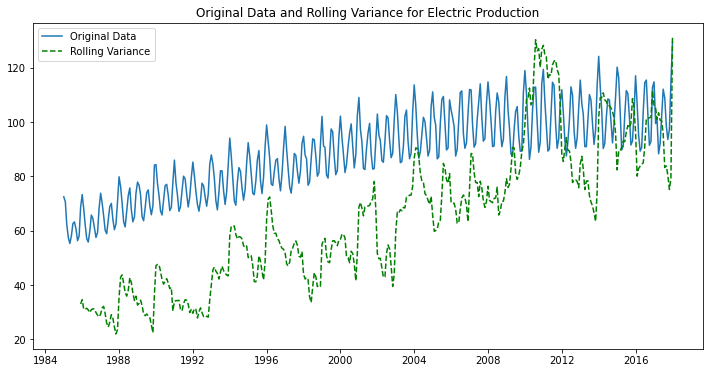

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(electric_data['IPG2211A2N'], label='Original Data')
plt.plot(rolvar, label='Rolling Variance', color='green', linestyle='dashed') 
plt.title('Original Data and Rolling Variance for Electric Production')
plt.legend()
plt.show()

In [7]:
result = adfuller(electric_data['IPG2211A2N'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Electric Production is Stationary (reject the null hypothesis)")
else:
    print("Electric Production is Non-stationary (fail to reject the null hypothesis)")

ADF Statistic: -2.25699035004725
p-value: 0.18621469116586592
Critical Values: {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}
Electric Production is Non-stationary (fail to reject the null hypothesis)


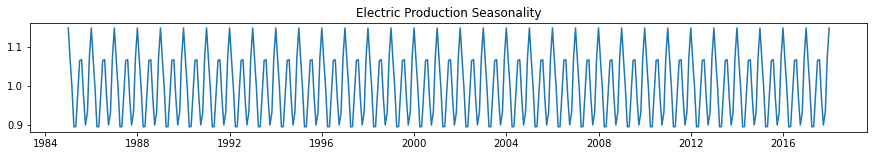

In [8]:
result = seasonal_decompose(electric_data['IPG2211A2N'], model='multiplicative', period=12)

plt.figure(figsize=(15, 2))
plt.plot(result.seasonal)
plt.title('Electric Production Seasonality')
plt.show()

In [9]:
def differencing(data):
    q = 0
    while(True):
        result = adfuller(data)
        if result[1] <= 0.05:
            break
        data = np.log(data)
        data = data.diff().dropna()
        q += 1
    return data, q

In [10]:
electric_data_stationary, optimal_d = differencing(electric_data)

In [11]:
electric_data_stationary

,IPG2211A2N
DATE,
1985-02-01,-0.025609
1985-03-01,-0.123680
1985-04-01,-0.083082
1985-05-01,-0.038242
1985-06-01,0.048954
...,...
2017-09-01,-0.099489
2017-10-01,-0.052051
2017-11-01,0.038991


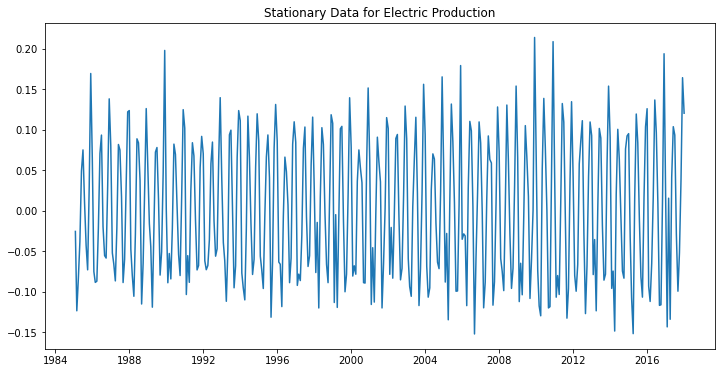

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(electric_data_stationary['IPG2211A2N'])
plt.title('Stationary Data for Electric Production')
plt.show()

In [13]:
result = adfuller(electric_data_stationary['IPG2211A2N'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("Electric Production is Stationary (reject the null hypothesis)")
else:
    print("Electric Production is Non-stationary (fail to reject the null hypothesis)")

ADF Statistic: -6.748333370019134
p-value: 2.9951614981160046e-09
Critical Values: {'1%': -3.4476305904172904, '5%': -2.869155980820355, '10%': -2.570827146203181}
Electric Production is Stationary (reject the null hypothesis)


In [14]:
train_end = pd.to_datetime('2013-12-01')
test_end = pd.to_datetime('2017-12-01')

train_data = electric_data_stationary.loc[:train_end]
test_data = electric_data_stationary.loc[train_end+pd.DateOffset(days=1):test_end]

In [15]:
train_data

,IPG2211A2N
DATE,
1985-02-01,-0.025609
1985-03-01,-0.123680
1985-04-01,-0.083082
1985-05-01,-0.038242
1985-06-01,0.048954
...,...
2013-08-01,-0.018069
2013-09-01,-0.085803
2013-10-01,-0.078481


In [16]:
test_data

,IPG2211A2N
DATE,
2014-01-01,0.090768
2014-02-01,-0.096000
2014-03-01,-0.074633
2014-04-01,-0.148711
2014-05-01,0.020254
2014-06-01,0.100532
2014-07-01,0.063432
2014-08-01,-0.003282
2014-09-01,-0.074592


In [17]:
pacf_values, pacf_confint = pacf(electric_data_stationary, alpha=0.05)
significant_lags = np.where(np.abs(pacf_values) > pacf_confint[:, 1])[0]

print("Significant Lags based on PACF:")
print(significant_lags)

optimal_p = max(significant_lags, default=1)
print("\nOptimal p based on PACF:")
print(optimal_p)

Significant Lags based on PACF:
[ 2  3  4  8  9 10 11 15 16 22 23]

Optimal p based on PACF:
23


<Figure size 864x1440 with 0 Axes>

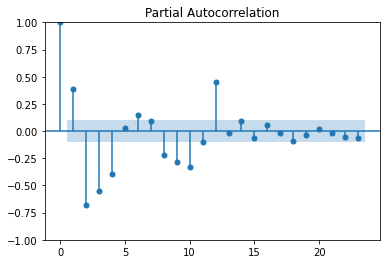

In [18]:
plt.figure(figsize=(12, 20))
plot_pacf(electric_data_stationary, lags=optimal_p)   
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


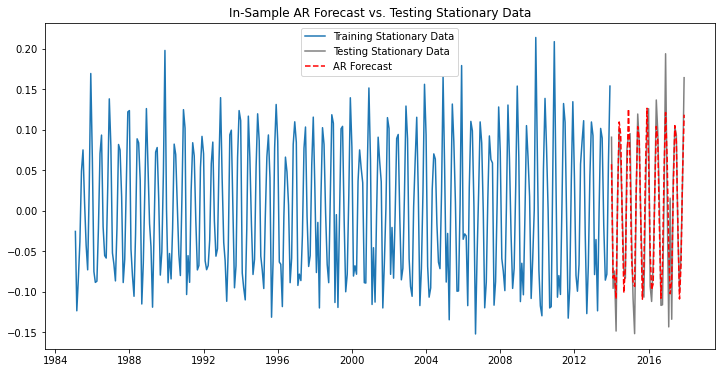

Optimal lag order (p) based on PACF: 23
RMSE (AR): 0.036761266979860645
R-squared (AR): 0.8452573595148535
MSE (AR): 0.0013513907499645924
MAPE (AR): 0.7015495563203937%


In [19]:
AR_model = ARIMA(train_data, order=(optimal_p, 0, 0))
results = AR_model.fit()

AR_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Stationary Data')
plt.plot(test_data, label='Testing Stationary Data', color='gray')
plt.plot(AR_forecast, label='AR Forecast', color='red', linestyle='--')
plt.title('In-Sample AR Forecast vs. Testing Stationary Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, AR_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, AR_forecast)
mape = mean_absolute_percentage_error(test_data, AR_forecast)

print(f"Optimal lag order (p) based on PACF: {optimal_p}")
print(f"RMSE (AR): {rmse}")
print(f"R-squared (AR): {r2}")
print(f"MSE (AR): {mse}")
print(f"MAPE (AR): {mape}%")

In [20]:
acf_values, acf_confint = acf(electric_data_stationary, alpha=0.05)
significant_lags = np.where(np.abs(acf_values) > acf_confint[:, 1])[0]

print("Significant Lags based on ACF:")
print(significant_lags)

optimal_q = max(significant_lags, default=1)
print("\nOptimal q based on ACF:")
print(optimal_q)

Significant Lags based on ACF:
[ 2  3  4  8  9 10 14 15 16 20 21 22]

Optimal q based on ACF:
22


<Figure size 864x1440 with 0 Axes>

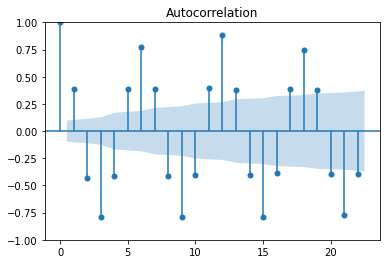

In [21]:
plt.figure(figsize=(12, 20))
plot_acf(electric_data_stationary, lags=optimal_q)   
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\srina\appdata\local\pro

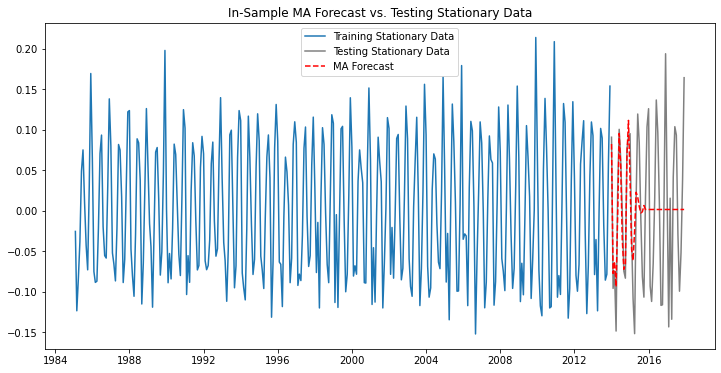

Optimal lag order (q) based on ACF: 22
RMSE (MA): 0.0805421526827012
R-squared (MA): 0.2571937875186697
MSE (MA): 0.006487038358763553
MAPE (MA): 0.9493020018267191%


In [22]:
MA_model = ARIMA(train_data, order=(0, 0, optimal_q))
results = MA_model.fit()

MA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Stationary Data')
plt.plot(test_data, label='Testing Stationary Data', color='gray')
plt.plot(MA_forecast, label='MA Forecast', color='red', linestyle='--')
plt.title('In-Sample MA Forecast vs. Testing Stationary Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, MA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, MA_forecast)
mape = mean_absolute_percentage_error(test_data, MA_forecast)

print(f"Optimal lag order (q) based on ACF: {optimal_q}")
print(f"RMSE (MA): {rmse}")
print(f"R-squared (MA): {r2}")
print(f"MSE (MA): {mse}")
print(f"MAPE (MA): {mape}%")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\

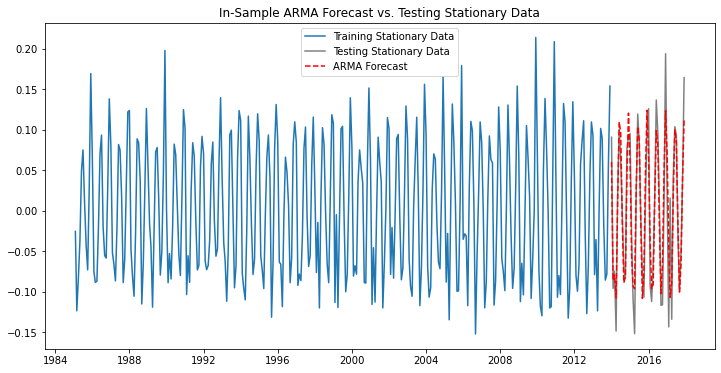

Optimal lag order (p, q) based on PACF and ACF: (23, 22)
RMSE (ARMA): 0.03723762577246091
R-squared (ARMA): 0.8412210127601591
MSE (ARMA): 0.001386640773169845
MAPE (ARMA): 0.705924492803868%


In [23]:
ARMA_model = ARIMA(train_data, order=(optimal_p, 0, optimal_q))
results = ARMA_model.fit()

ARMA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Stationary Data')
plt.plot(test_data, label='Testing Stationary Data', color='gray')
plt.plot(ARMA_forecast, label='ARMA Forecast', color='red', linestyle='--')
plt.title('In-Sample ARMA Forecast vs. Testing Stationary Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, ARMA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, ARMA_forecast)
mape = mean_absolute_percentage_error(test_data, ARMA_forecast)

print(f"Optimal lag order (p, q) based on PACF and ACF: ({optimal_p}, {optimal_q})")
print(f"RMSE (ARMA): {rmse}")
print(f"R-squared (ARMA): {r2}")
print(f"MSE (ARMA): {mse}")
print(f"MAPE (ARMA): {mape}%")

In [24]:
train_end = pd.to_datetime('2013-12-01')
test_end = pd.to_datetime('2017-12-01')

train_data = electric_data.loc[:train_end]
test_data = electric_data.loc[train_end+pd.DateOffset(days=1):test_end]

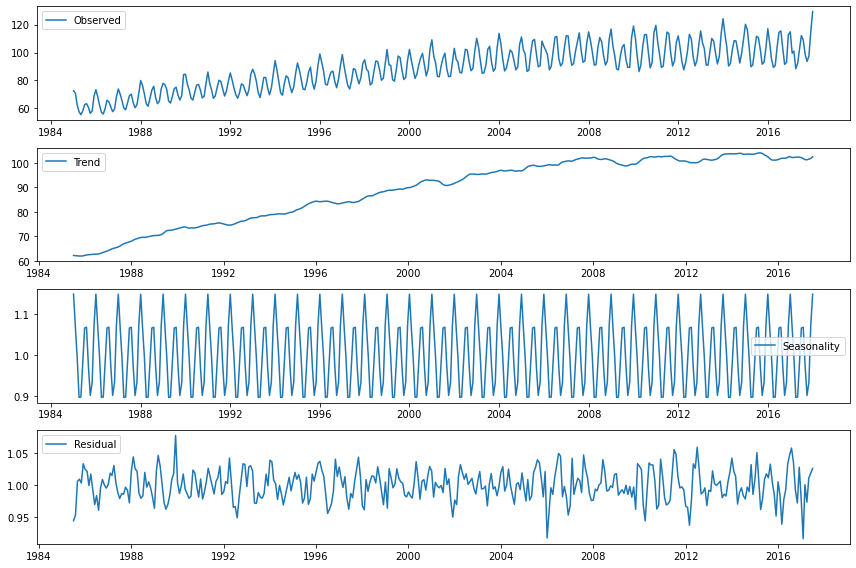

In [25]:
result = seasonal_decompose(electric_data['IPG2211A2N'], model='multiplicative', period=12)

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonality')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


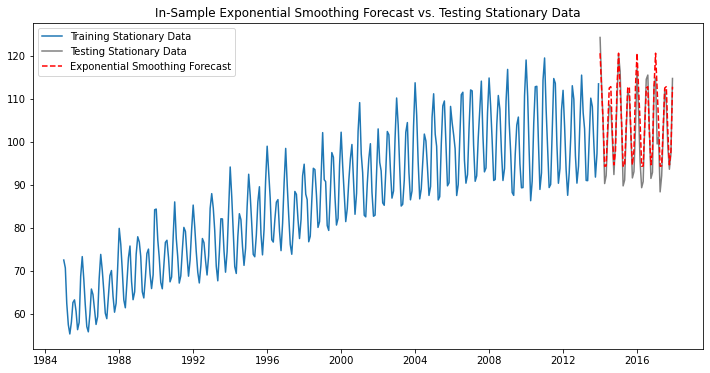

RMSE (Exponentional Smoothing): 4.012466567379388
R-squared (Exponentional Smoothing): 0.8217665517603081
MSE (Exponentional Smoothing): 16.09988795433733
MAPE (Exponentional Smoothing): 0.030820873086746373%


In [26]:
ES_model = ExponentialSmoothing(train_data, seasonal='mul')
results = ES_model.fit()

ES_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Stationary Data')
plt.plot(test_data, label='Testing Stationary Data', color='gray')
plt.plot(ES_forecast, label='Exponential Smoothing Forecast', color='red', linestyle='--')
plt.title('In-Sample Exponential Smoothing Forecast vs. Testing Stationary Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, ES_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, ES_forecast)
mape = mean_absolute_percentage_error(test_data, ES_forecast)

print(f"RMSE (Exponentional Smoothing): {rmse}")
print(f"R-squared (Exponentional Smoothing): {r2}")
print(f"MSE (Exponentional Smoothing): {mse}")
print(f"MAPE (Exponentional Smoothing): {mape}%")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\

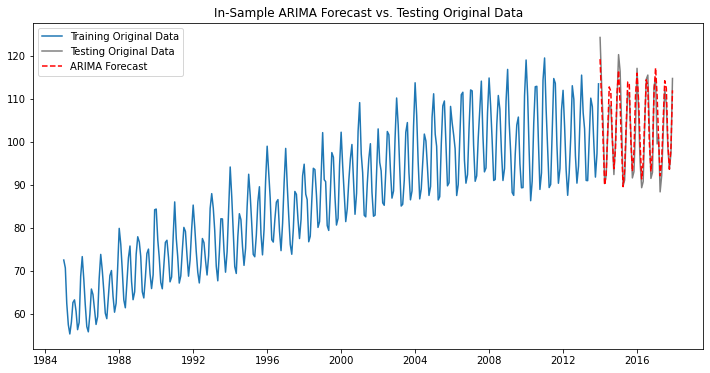

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (23, 1, 22)
RMSE (ARIMA): 3.4927706631289164
R-squared (ARIMA): 0.8649462968500002
MSE (ARIMA): 12.19944690521401
MAPE (ARIMA): 0.026588862152284645%


In [27]:
ARIMA_model = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q))
results = ARIMA_model.fit()

ARIMA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Original Data')
plt.plot(test_data, label='Testing Original Data', color='gray')
plt.plot(ARIMA_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('In-Sample ARIMA Forecast vs. Testing Original Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, ARIMA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, ARIMA_forecast)
mape = mean_absolute_percentage_error(test_data, ARIMA_forecast)

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({optimal_p}, {optimal_d}, {optimal_q})")
print(f"RMSE (ARIMA): {rmse}")
print(f"R-squared (ARIMA): {r2}")
print(f"MSE (ARIMA): {mse}")
print(f"MAPE (ARIMA): {mape}%")

In [28]:
electric_data_seasonal = seasonal_decompose(electric_data['IPG2211A2N'], model='multiplicative', period=12).seasonal
electric_data_seasonal_stationary, optimal_D = differencing(electric_data_seasonal)

In [29]:
optimal_D

0

<Figure size 864x1440 with 0 Axes>

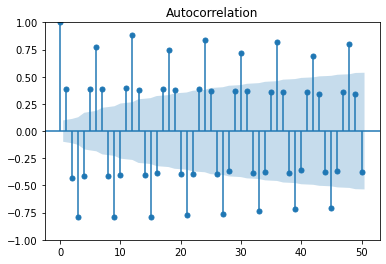

In [30]:
plt.figure(figsize=(12, 20))
plot_acf(electric_data_stationary, lags=50)
plt.show()

<Figure size 864x1440 with 0 Axes>

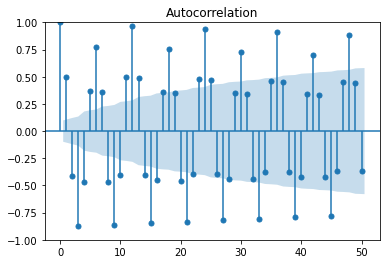

In [31]:
plt.figure(figsize=(12, 20))
plot_acf(electric_data_seasonal_stationary, lags=50)
plt.show()

<Figure size 864x1440 with 0 Axes>

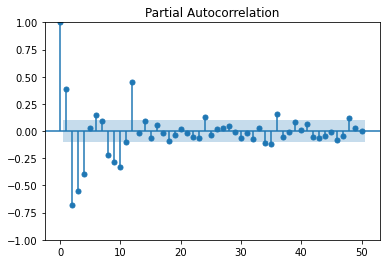

In [32]:
plt.figure(figsize=(12, 20))
plot_pacf(electric_data_stationary, lags=50)
plt.show()

<Figure size 864x1440 with 0 Axes>

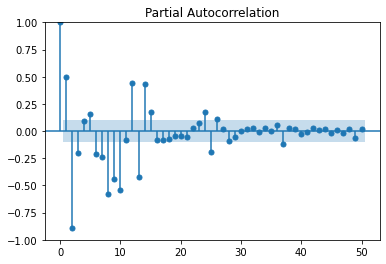

In [33]:
plt.figure(figsize=(12, 20))
plot_pacf(electric_data_seasonal_stationary, lags=50)
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


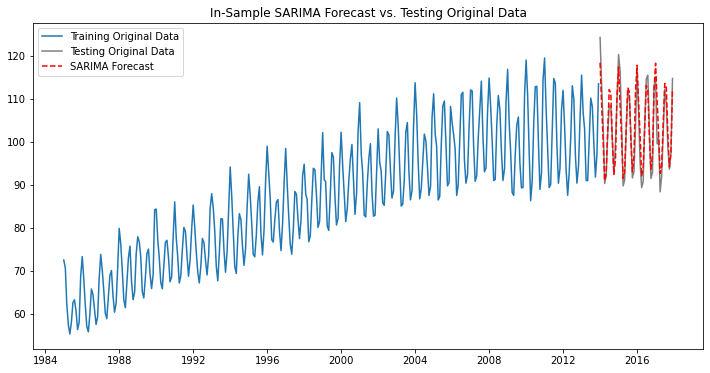

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (3, 1, 1)
Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: (1, 0, 1)
RMSE (SARIMA): 3.401804352921756
R-squared (SARIMA): 0.8718894130899262
MSE (SARIMA): 11.572272855557408
MAPE (SARIMA): 0.02570613289706175%


In [34]:
SARIMA_model = SARIMAX(train_data, order=(3, optimal_d, 1), seasonal_order = (1, optimal_D, 1, 12))
results = SARIMA_model.fit()

SARIMA_forecast = results.predict(start=test_data.index[0], end=test_data.index[-1])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Original Data')
plt.plot(test_data, label='Testing Original Data', color='gray')
plt.plot(SARIMA_forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('In-Sample SARIMA Forecast vs. Testing Original Data')
plt.legend()
plt.show()

mse = mean_squared_error(test_data, SARIMA_forecast)
rmse = sqrt(mse)
r2 = r2_score(test_data, SARIMA_forecast)
mape = mean_absolute_percentage_error(test_data, SARIMA_forecast)

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({3}, {optimal_d}, {1})")
print(f"Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: ({1}, {optimal_D}, {1})")
print(f"RMSE (SARIMA): {rmse}")
print(f"R-squared (SARIMA): {r2}")
print(f"MSE (SARIMA): {mse}")
print(f"MAPE (SARIMA): {mape}%")

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = pd.concat([train_data, test_data])
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
data['IPG2211A2N'] = scaled_data
print(data)

            IPG2211A2N
DATE                  
1985-01-01    0.249349
1985-02-01    0.222758
1985-03-01    0.103498
1985-04-01    0.031278
1985-05-01    0.000000
...                ...
2017-08-01    0.777723
2017-09-01    0.628089
2017-10-01    0.555537
2017-11-01    0.609529
2017-12-01    0.861710

[396 rows x 1 columns]


In [36]:
seq_len = 24

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len):
    sequences = split_into_sequences(data, seq_len)
    
    train_end = pd.to_datetime('2013-12-01')
    n_train = len(data.loc[:train_end]) - seq_len + 1
    
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_train_test_sets(data, seq_len)

In [37]:
dropout = 0.2
window_size = seq_len - 1

model = keras.Sequential()
model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
model.add(Activation('linear'))

In [38]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=150,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/150
17/17 [==============================] - 8s 116ms/step - loss: 0.0222 - val_loss: 0.0195
Epoch 2/150
17/17 [==============================] - 0s 20ms/step - loss: 0.0185 - val_loss: 0.0288
Epoch 3/150
17/17 [==============================] - 0s 20ms/step - loss: 0.0155 - val_loss: 0.0246
Epoch 4/150
17/17 [==============================] - 0s 18ms/step - loss: 0.0125 - val_loss: 0.0224
Epoch 5/150
17/17 [==============================] - 0s 20ms/step - loss: 0.0121 - val_loss: 0.0202
Epoch 6/150
17/17 [==============================] - 0s 19ms/step - loss: 0.0115 - val_loss: 0.0199
Epoch 7/150
17/17 [==============================] - 0s 19ms/step - loss: 0.0112 - val_loss: 0.0203
Epoch 8/150
17/17 [==============================] - 0s 19ms/step - loss: 0.0118 - val_loss: 0.0208
Epoch 9/150
17/17 [==============================] - 0s 18ms/step - loss: 0.0121 - val_loss: 0.0222
Epoch 10/150
17/17 [==============================] - 0s 18ms/step - loss: 0.0127 - val_loss: 0.021

17/17 [==============================] - 0s 21ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 83/150
17/17 [==============================] - 0s 22ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 84/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 85/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0089
Epoch 86/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 87/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 88/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 89/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0048 - val_loss: 0.0055
Epoch 90/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 91/150
17/17 [==============================] - 0s 21ms/step - loss: 0.0055 - val_loss: 0.0073
Epo

In [39]:
y_pred = model.predict(x_test)

y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

2/2 [==============================] - 1s 7ms/step


DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)


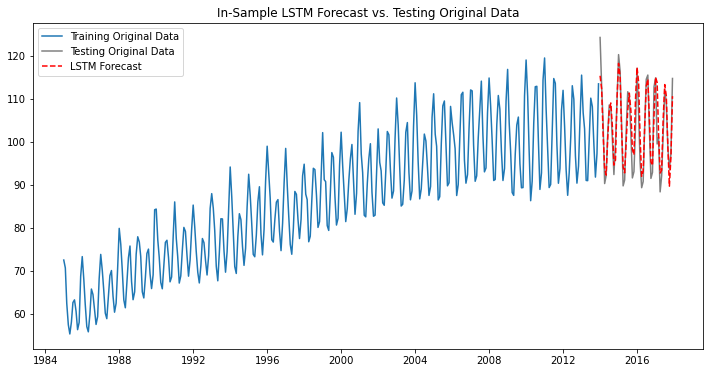

RMSE (LSTM): 3.9849369999724837
R-squared (LSTM): 0.8242038841219823
MSE (LSTM): 15.8797228937497
MAPE (LSTM): 0.02902811494881834%


In [40]:
test_dates = data[-len(y_test_orig):].index

print(test_dates)

y_test_df = pd.DataFrame(y_test_orig, index=test_dates)
y_pred_df = pd.DataFrame(y_pred_orig, index=test_dates)

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Original Data')
plt.plot(y_test_df, label='Testing Original Data', color='gray')
plt.plot(y_pred_df, label='LSTM Forecast', color='red', linestyle='--')

plt.title('In-Sample LSTM Forecast vs. Testing Original Data')
plt.legend()
plt.show()

mse = mean_squared_error(y_test_df, y_pred_df)
rmse = sqrt(mse)
r2 = r2_score(y_test_df, y_pred_df)
mape = mean_absolute_percentage_error(y_test_df, y_pred_df)

print(f"RMSE (LSTM): {rmse}")
print(f"R-squared (LSTM): {r2}")
print(f"MSE (LSTM): {mse}")
print(f"MAPE (LSTM): {mape}%")

In [41]:
train_data = electric_data_stationary[:]
year_1 = pd.date_range(start=train_data.index[-1], periods=12, freq='MS')[1:]
year_2 = pd.date_range(start=year_1[-1], periods=13, freq='MS')[1:]
year_3 = pd.date_range(start=year_2[-1], periods=13, freq='MS')[1:]
year_4 = pd.date_range(start=year_3[-1], periods=13, freq='MS')[1:]
full = pd.date_range(start=train_data.index[-1], periods=12*4, freq='MS')[1:]

test_data = [year_1, year_2, year_3, year_4, full]
print(test_data)

[DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS'), DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS'), DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS'), DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
       

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\

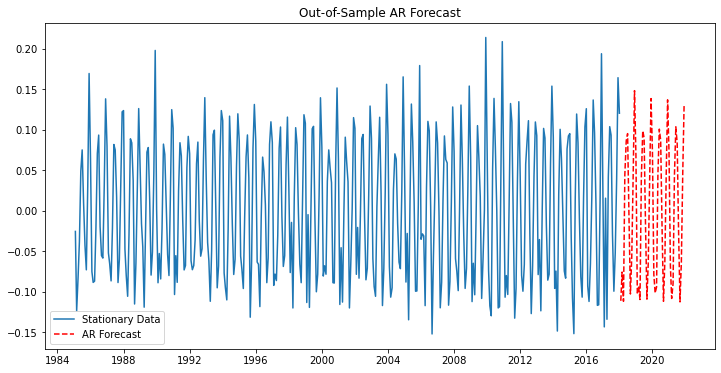

Optimal lag order (p) based on PACF: 23


In [42]:
AR_model = ARIMA(train_data, order=(optimal_p, 0, 0))
results = AR_model.fit()

AR_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
AR_forecast = pd.DataFrame(AR_forecast)
AR_forecast = AR_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
full_forecast = AR_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, AR_forecast])
    AR_model = ARIMA(temp, order=(optimal_p, 0, 0))
    results = AR_model.fit()

    AR_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    AR_forecast = pd.DataFrame(AR_forecast)
    AR_forecast = AR_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
    full_forecast = pd.concat([full_forecast, AR_forecast])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Stationary Data')
plt.plot(full_forecast, label='AR Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample AR Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p) based on PACF: {optimal_p}")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\srina\appdata\local\pro

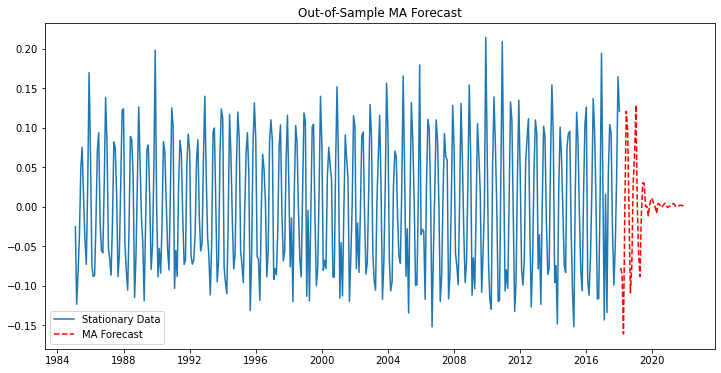

Optimal lag order (q) based on ACF: 22


In [43]:
MA_model = ARIMA(train_data, order=(0, 0, optimal_q))
results = MA_model.fit()

MA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
MA_forecast = pd.DataFrame(MA_forecast)
MA_forecast = MA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
full_forecast = MA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, MA_forecast])
    MA_model = ARIMA(temp, order=(0, 0, optimal_q))
    results = MA_model.fit()

    MA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    MA_forecast = pd.DataFrame(MA_forecast)
    MA_forecast = MA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
    full_forecast = pd.concat([full_forecast, MA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Stationary Data')
plt.plot(full_forecast, label='MA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample MA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (q) based on ACF: {optimal_q}")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\

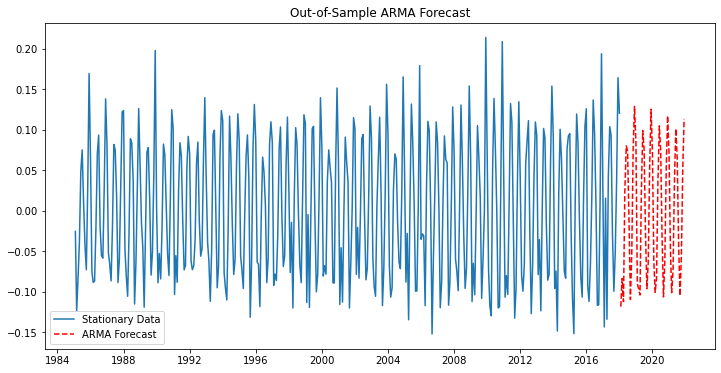

Optimal lag order (p, q) based on PACF and ACF: (23, 22)


In [44]:
ARMA_model = ARIMA(train_data, order=(optimal_p, 0, optimal_q))
results = ARMA_model.fit()

ARMA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
ARMA_forecast = pd.DataFrame(ARMA_forecast)
ARMA_forecast = ARMA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
full_forecast = ARMA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, ARMA_forecast])
    ARMA_model = ARIMA(temp, order=(optimal_p, 0, optimal_q))
    results = ARMA_model.fit()

    ARMA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    ARMA_forecast = pd.DataFrame(ARMA_forecast)
    ARMA_forecast = ARMA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
    full_forecast = pd.concat([full_forecast, ARMA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Stationary Data')
plt.plot(full_forecast, label='ARMA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample ARMA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p, q) based on PACF and ACF: ({optimal_p}, {optimal_q})")

In [45]:
train_data = electric_data[:]
year_1 = pd.date_range(start=train_data.index[-1], periods=12, freq='MS')[1:]
year_2 = pd.date_range(start=year_1[-1], periods=13, freq='MS')[1:]
year_3 = pd.date_range(start=year_2[-1], periods=13, freq='MS')[1:]
year_4 = pd.date_range(start=year_3[-1], periods=13, freq='MS')[1:]
full = pd.date_range(start=train_data.index[-1], periods=12*4, freq='MS')[1:]

test_data = [year_1, year_2, year_3, year_4, full]
print(test_data)

[DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', freq='MS'), DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS'), DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS'), DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
       

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


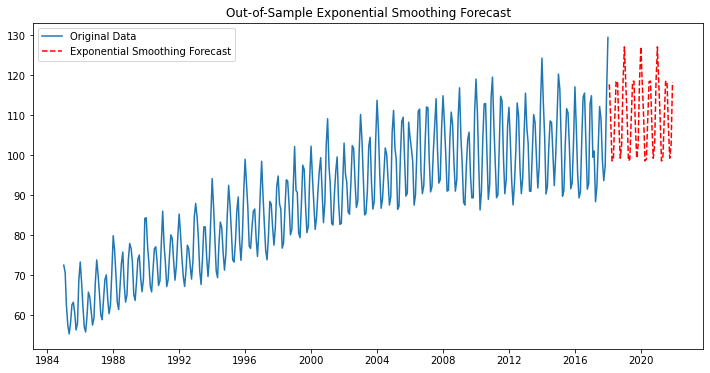

In [46]:
ES_model = ExponentialSmoothing(train_data, seasonal='mul')
results = ES_model.fit()

ES_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
ES_forecast = pd.DataFrame(ES_forecast, columns=['IPG2211A2N'])
full_forecast = ES_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, ES_forecast])
    ES_model = ExponentialSmoothing(temp, seasonal='mul')
    results = ES_model.fit()

    ES_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    ES_forecast = pd.DataFrame(ES_forecast, columns=['IPG2211A2N'])
    full_forecast = pd.concat([full_forecast, ES_forecast])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Original Data')
plt.plot(full_forecast, label='Exponential Smoothing Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample Exponential Smoothing Forecast')
plt.legend()
plt.show()

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\users\srina\

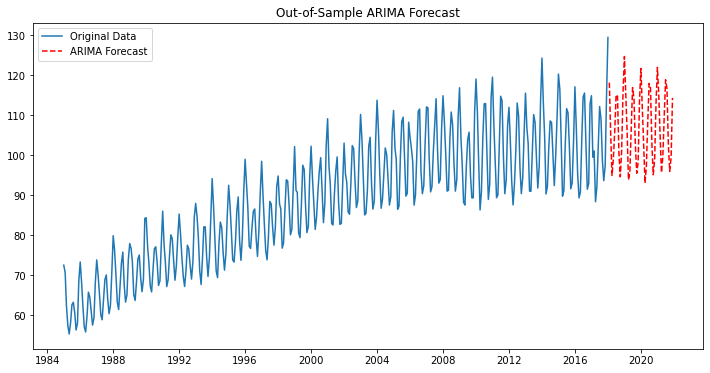

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (23, 1, 22)


In [47]:
ARIMA_model = ARIMA(train_data, order=(optimal_p, optimal_d, optimal_q))
results = ARIMA_model.fit()

ARIMA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
ARIMA_forecast = pd.DataFrame(ARIMA_forecast)
ARIMA_forecast = ARIMA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
full_forecast = ARIMA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, ARIMA_forecast])
    ARIMA_model = ARIMA(temp, order=(optimal_p, optimal_d, optimal_q))
    results = ARIMA_model.fit()

    ARIMA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    ARIMA_forecast = pd.DataFrame(ARIMA_forecast)
    ARIMA_forecast = ARIMA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
    full_forecast = pd.concat([full_forecast, ARIMA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Original Data')
plt.plot(full_forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample ARIMA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({optimal_p}, {optimal_d}, {optimal_q})")

c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\users\srina\appdata\local\programs\python\python39\lib\si

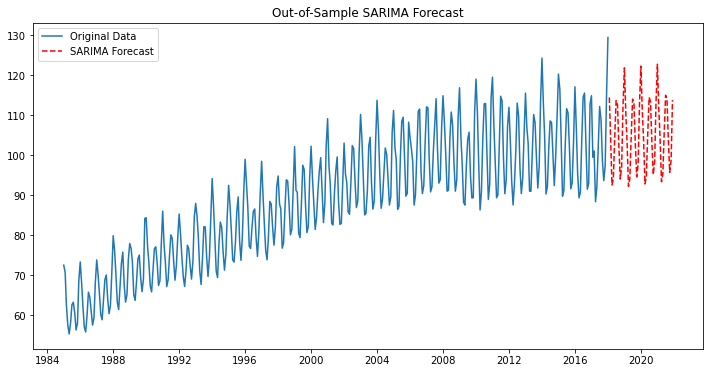

Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: (3, 1, 1)
Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: (1, 0, 1)


In [48]:
SARIMA_model = SARIMAX(train_data, order=(3, optimal_d, 1), seasonal_order = (1, optimal_D, 1, 12))
results = SARIMA_model.fit()

SARIMA_forecast = results.predict(start=test_data[0][0], end=test_data[0][-1])
SARIMA_forecast = pd.DataFrame(SARIMA_forecast)
SARIMA_forecast = SARIMA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
full_forecast = SARIMA_forecast.copy(deep=True)

temp = train_data.copy(deep=True)
for i in range(1, len(test_data)-1):
    temp = pd.concat([temp, SARIMA_forecast])
    SARIMA_model = SARIMAX(temp, order=(3, optimal_d, 1), seasonal_order = (1, optimal_D, 1, 12))
    results = SARIMA_model.fit()

    SARIMA_forecast = results.predict(start=test_data[i][0], end=test_data[i][-1])
    SARIMA_forecast = pd.DataFrame(SARIMA_forecast)
    SARIMA_forecast = SARIMA_forecast.rename(columns={'predicted_mean': 'IPG2211A2N'})
    full_forecast = pd.concat([full_forecast, SARIMA_forecast])

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Original Data')
plt.plot(full_forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.title('Out-of-Sample SARIMA Forecast')
plt.legend()
plt.show()

print(f"Optimal lag order (p, d, q) based on PACF, ADF Test and ACF: ({3}, {optimal_d}, {1})")
print(f"Optimal lag order (P, D, Q) based on Seasonal PACF, ADF Test and Seasonal ACF: ({1}, {optimal_D}, {1})")

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = train_data[:]
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
data['IPG2211A2N'] = scaled_data
print(data)

            IPG2211A2N
DATE                  
1985-01-01    0.232017
1985-02-01    0.207274
1985-03-01    0.096304
1985-04-01    0.029104
1985-05-01    0.000000
...                ...
2017-09-01    0.584431
2017-10-01    0.516922
2017-11-01    0.567161
2017-12-01    0.801813
2018-01-01    1.000000

[397 rows x 1 columns]


In [50]:
seq_len = 24

def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len):
    sequences = split_into_sequences(data, seq_len)
    
    train_end = pd.to_datetime('2018-01-01')
    n_train = len(data.loc[:train_end]) - seq_len + 1
    
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    
    return x_train, y_train

x_train, y_train = get_train_test_sets(data, seq_len)

In [51]:
dropout = 0.2
window_size = seq_len - 1

model = keras.Sequential()
model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
model.add(Activation('linear'))

In [52]:
batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=150,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/150
19/19 [==============================] - 7s 88ms/step - loss: 0.0188 - val_loss: 0.0202
Epoch 2/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0217 - val_loss: 0.0219
Epoch 3/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0190 - val_loss: 0.0272
Epoch 4/150
19/19 [==============================] - 0s 17ms/step - loss: 0.0190 - val_loss: 0.0233
Epoch 5/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0144 - val_loss: 0.0201
Epoch 6/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0119 - val_loss: 0.0182
Epoch 7/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0120 - val_loss: 0.0180
Epoch 8/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0118 - val_loss: 0.0179
Epoch 9/150
19/19 [==============================] - 0s 17ms/step - loss: 0.0117 - val_loss: 0.0181
Epoch 10/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0115 - val_loss: 0.0180

19/19 [==============================] - 0s 18ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 83/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0056 - val_loss: 0.0087
Epoch 84/150
19/19 [==============================] - 0s 19ms/step - loss: 0.0064 - val_loss: 0.0057
Epoch 85/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 86/150
19/19 [==============================] - 0s 19ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 87/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 88/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 89/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 90/150
19/19 [==============================] - 0s 19ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 91/150
19/19 [==============================] - 0s 18ms/step - loss: 0.0072 - val_loss: 0.0069
Epo

In [53]:
input_sequence = x_train[-1]

predicted_values = np.empty((0, 1))
for _ in range(4 * 12 - 1):
    predicted_value = model.predict(input_sequence.reshape(1, seq_len-1, 1))

    predicted_values = np.append(predicted_values, predicted_value, axis=0)

    input_sequence = np.append(input_sequence[1:], predicted_value, axis=0)

1/1 [==============================] - 0s 16ms/step


In [54]:
y_train_orig = scaler.inverse_transform(y_train)
y_pred_orig = scaler.inverse_transform(predicted_values)

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01',
               '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', freq='MS')


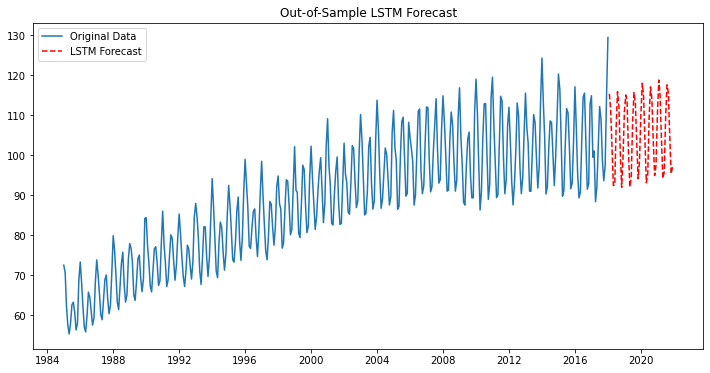

In [55]:
test_dates = test_data[-1]

print(test_dates)

y_pred_df = pd.DataFrame(y_pred_orig, index=test_dates)

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Original Data')
plt.plot(y_pred_df, label='LSTM Forecast', color='red', linestyle='--')

plt.title('Out-of-Sample LSTM Forecast')
plt.legend()
plt.show()